In [ ]:
print("hello")

hello


In [ ]:
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00


Number of categories: 8
Category distribution:
Category
housekeeping          155
maintenance           124
customer service      121
catering              115
train operations       86
security               41
medical and health     35
luggage                26
Name: count, dtype: int64


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Training ensemble model on BERT embeddings + numerical features...
Training Logistic Regression on TF-IDF features...
Ensemble Model Accuracy (BERT + numerical): 0.6879
TF-IDF Logistic Regression Accuracy: 0.6383
Final Weighted Ensemble Accuracy: 0.7021

Classification Report:
                      precision    recall  f1-score   support

          0:catering       0.90      0.78      0.84        23
  1:customer service       0.66      0.76      0.70        25
      2:housekeeping       0.83      0.94      0.88        31
           3:luggage       0.80      0.80      0.80         5
       4:maintenance       0.59      0.52      0.55        25
5:medical and health       0.67      0.57      0.62         7
          6:security       0.67      0.50      0.57         8
  7:train operations       0.44      0.47      0.46        17

            accuracy                           0.70       141
           macro avg       0.69      0.67      0.68       141
        weighted avg       0.70      0

'\n# Save the model for deployment\nimport pickle\nmodel_artifacts = {\n    \'label_encoder\': label_encoder,\n    \'tfidf_vectorizer\': tfidf_vectorizer,\n    \'ensemble_model\': ensemble_model,\n    \'lr_tfidf\': lr_tfidf,\n    \'embedder\': embedder\n}\n\nwith open(\'grievance_classification_model.pkl\', \'wb\') as f:\n    pickle.dump(model_artifacts, f)\n\nprint("\nModel artifacts saved to \'grievance_classification_model.pkl\'")\n\n# Function for making predictions on new data\ndef predict_category(text, model_artifacts):\n    # Preprocess text\n    processed_text = enhanced_preprocess_text(text)\n    \n    # Extract features\n    word_count = len(processed_text.split())\n    char_count = len(processed_text)\n    \n    # TF-IDF features\n    tfidf_features = model_artifacts[\'tfidf_vectorizer\'].transform([processed_text])\n    \n    # BERT embeddings\n    bert_embedding = model_artifacts[\'embedder\'].encode([processed_text], convert_to_numpy=True)\n    \n    # Numerical features

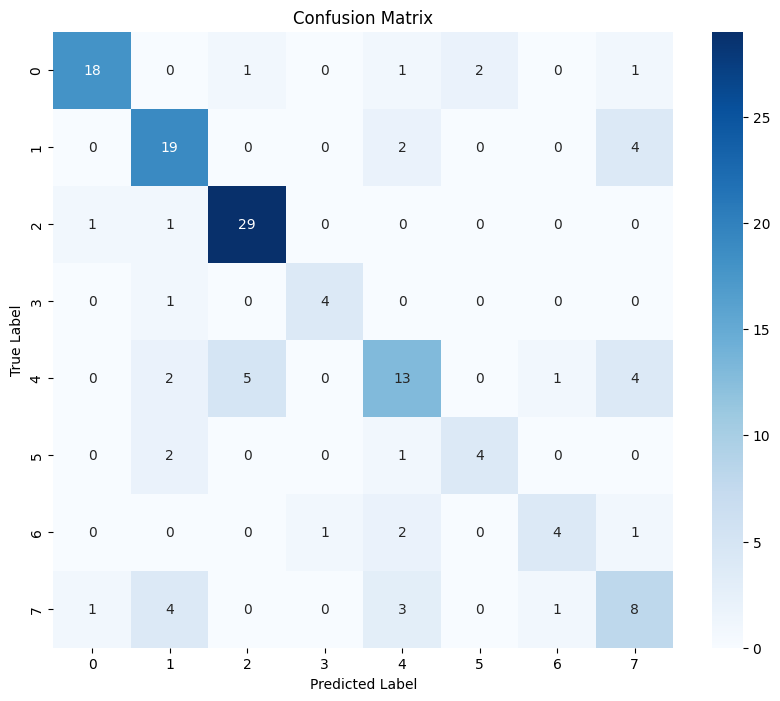

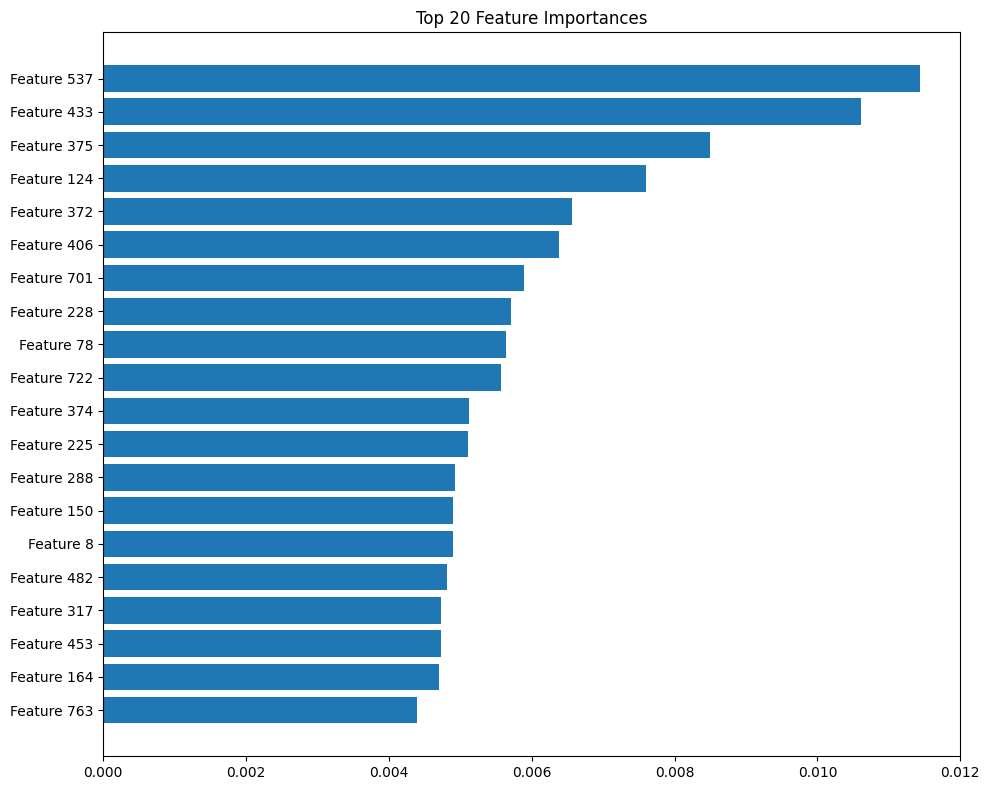

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
import torch
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('processed_dataset_7.csv', encoding='ISO-8859-1')
df["Category"] = df["Category"].str.strip().str.lower()
df = df[df["Category"] != "703"].reset_index(drop=True)

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Improved text preprocessing with additional cleaning and n-gram preservation
def enhanced_preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters but preserve some punctuation that might be meaningful
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens
                     if token not in stop_words and len(token) > 2]

    return ' '.join(cleaned_tokens)

# Apply enhanced preprocessing
df['processed_description'] = df['Grievance Description'].apply(enhanced_preprocess_text)

# Feature engineering: Create additional features from text
df['word_count'] = df['processed_description'].apply(lambda x: len(x.split()))
df['char_count'] = df['processed_description'].apply(len)

# Add keyword features if available
if 'Complaint Keywords' in df.columns and not df['Complaint Keywords'].isna().all():
    df['processed_keywords'] = df['Complaint Keywords'].apply(enhanced_preprocess_text)
    df['combined_text'] = df['processed_description'] + ' ' + df['processed_keywords']
    df['keyword_count'] = df['processed_keywords'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
else:
    df['combined_text'] = df['processed_description']
    df['keyword_count'] = 0

# Extract key phrases (bigrams/trigrams) that might be indicative of categories
from nltk.util import ngrams

def extract_ngrams(text, n=2):
    tokens = text.split()
    n_grams = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in n_grams]

df['bigrams'] = df['combined_text'].apply(lambda x: extract_ngrams(x, 2))
df['trigrams'] = df['combined_text'].apply(lambda x: extract_ngrams(x, 3))

# Prepare labeled data
labeled_df = df.dropna(subset=['Category']).reset_index(drop=True)

# Encode categories
label_encoder = LabelEncoder()
labeled_df['encoded_category'] = label_encoder.fit_transform(labeled_df['Category'])

# Print category distribution
category_counts = labeled_df['Category'].value_counts()
print(f"Number of categories: {len(category_counts)}")
print(f"Category distribution:\n{category_counts.head(10)}")

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    labeled_df[['combined_text', 'word_count', 'char_count', 'keyword_count']],
    labeled_df['encoded_category'],
    test_size=0.2,
    random_state=42,
    stratify=labeled_df['encoded_category']
)

# Create a more robust TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Increased from 5000
    ngram_range=(1, 3),  # Include trigrams
    min_df=2,
    max_df=0.9,         # Remove terms that appear in more than 90% of documents
    use_idf=True,
    sublinear_tf=True,   # Apply sublinear tf scaling (1 + log(tf))
    norm='l2'
)

# Create a sentence transformer with a more powerful model
embedder = SentenceTransformer("paraphrase-mpnet-base-v2")  # Upgrade from MiniLM to MPNet

# Fit TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['combined_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['combined_text'])

# Generate embeddings
X_train_bert = embedder.encode(X_train['combined_text'].tolist(), batch_size=8, convert_to_numpy=True)
X_test_bert = embedder.encode(X_test['combined_text'].tolist(), batch_size=8, convert_to_numpy=True)

# Create numerical features
X_train_num = X_train[['word_count', 'char_count', 'keyword_count']].values
X_test_num = X_test[['word_count', 'char_count', 'keyword_count']].values

# Combine BERT embeddings with numerical features
X_train_combined = np.hstack((X_train_bert, X_train_num))
X_test_combined = np.hstack((X_test_bert, X_test_num))

# Add class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Try multiple models

# 1. Logistic Regression with optimized parameters
lr_model = LogisticRegression(
    C=10,
    max_iter=1000,
    solver='saga',
    penalty='l1',
    class_weight=class_weight_dict,
    multi_class='multinomial',
    random_state=42,
    n_jobs=-1
)

# 2. SVM with optimized parameters
svm_model = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    class_weight=class_weight_dict,
    probability=True,
    random_state=42
)

# 3. XGBoost Classifier
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Create and train ensemble model for BERT+numerical features
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('svm', svm_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

print("Training ensemble model on BERT embeddings + numerical features...")
ensemble_model.fit(X_train_combined, y_train)

# Train separate models for TFIDF
lr_tfidf = LogisticRegression(C=10, max_iter=1000, class_weight=class_weight_dict, random_state=42)
print("Training Logistic Regression on TF-IDF features...")
lr_tfidf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_ensemble = ensemble_model.predict(X_test_combined)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)

print(f"Ensemble Model Accuracy (BERT + numerical): {ensemble_accuracy:.4f}")
print(f"TF-IDF Logistic Regression Accuracy: {tfidf_accuracy:.4f}")

# Combine predictions from both models for better results
ensemble_proba = ensemble_model.predict_proba(X_test_combined)
tfidf_proba = lr_tfidf.predict_proba(X_test_tfidf)

# Weight BERT more heavily (0.7) than TF-IDF (0.3)
final_proba = 0.7 * ensemble_proba + 0.3 * tfidf_proba
final_predictions = np.argmax(final_proba, axis=1)

final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Weighted Ensemble Accuracy: {final_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
target_names = [f"{i}:{cat}" for i, cat in enumerate(label_encoder.classes_)]
print(classification_report(y_test, final_predictions, target_names=target_names))

# Confusion matrix for the most confused classes
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')

# Identify the most mispredicted categories
misclassified = y_test != final_predictions
if np.any(misclassified):
    y_test_misclassified = y_test[misclassified]
    y_pred_misclassified = final_predictions[misclassified]

    misclassification_counts = {}
    for true, pred in zip(y_test_misclassified, y_pred_misclassified):
        pair = (true, pred)
        misclassification_counts[pair] = misclassification_counts.get(pair, 0) + 1

    print("\nTop 10 most common misclassifications:")
    for (true, pred), count in sorted(misclassification_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        true_label = label_encoder.inverse_transform([true])[0]
        pred_label = label_encoder.inverse_transform([pred])[0]
        print(f"True: {true_label}, Predicted: {pred_label}, Count: {count}")

# Feature importance analysis
if hasattr(ensemble_model.estimators_[2], 'feature_importances_'):
    feature_importance = ensemble_model.estimators_[2].feature_importances_
    # For XGBoost, we can get feature importances
    top_features_count = min(20, len(feature_importance))
    top_indices = np.argsort(feature_importance)[-top_features_count:]
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_features_count), feature_importance[top_indices])
    plt.yticks(range(top_features_count), [f"Feature {i}" for i in top_indices])
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')


'''
# Save the model for deployment
import pickle
model_artifacts = {
    'label_encoder': label_encoder,
    'tfidf_vectorizer': tfidf_vectorizer,
    'ensemble_model': ensemble_model,
    'lr_tfidf': lr_tfidf,
    'embedder': embedder
}

with open('grievance_classification_model_70-21.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("\nModel artifacts saved to 'grievance_classification_model_70-21.pkl'")

# Function for making predictions on new data
def predict_category(text, model_artifacts):
    # Preprocess text
    processed_text = enhanced_preprocess_text(text)

    # Extract features
    word_count = len(processed_text.split())
    char_count = len(processed_text)

    # TF-IDF features
    tfidf_features = model_artifacts['tfidf_vectorizer'].transform([processed_text])

    # BERT embeddings
    bert_embedding = model_artifacts['embedder'].encode([processed_text], convert_to_numpy=True)

    # Numerical features
    numerical_features = np.array([[word_count, char_count, 0]])

    # Combined features
    combined_features = np.hstack((bert_embedding, numerical_features))

    # Get predictions from both models
    ensemble_proba = model_artifacts['ensemble_model'].predict_proba(combined_features)
    tfidf_proba = model_artifacts['lr_tfidf'].predict_proba(tfidf_features)

    # Weighted combination
    final_proba = 0.7 * ensemble_proba + 0.3 * tfidf_proba
    final_prediction = np.argmax(final_proba, axis=1)[0]

    # Decode the prediction
    category = model_artifacts['label_encoder'].inverse_transform([final_prediction])[0]

    return {
        'category': category,
        'confidence': final_proba[0][final_prediction],
        'top_3_categories': model_artifacts['label_encoder'].inverse_transform(np.argsort(final_proba[0])[-3:])[::-1]
    }

# Example of prediction usage
print("\nExample prediction:")
example_text = "The product I received was damaged during shipping and the packaging was torn."
with open('grievance_classification_model.pkl', 'rb') as f:
    loaded_artifacts = pickle.load(f)

prediction = predict_category(example_text, loaded_artifacts)
print(f"Predicted category: {prediction['category']}")
print(f"Confidence: {prediction['confidence']:.4f}")
print(f"Top 3 possible categories: {prediction['top_3_categories']}")'''

Number of categories: 8
Category distribution:
Category
housekeeping          155
maintenance           124
customer service      121
catering              115
train operations       86
security               41
medical and health     35
luggage                26
Name: count, dtype: int64


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Training ensemble model on BERT embeddings + numerical features...
Training Logistic Regression on TF-IDF features...
Ensemble Model Accuracy (BERT + numerical): 0.6879
TF-IDF Logistic Regression Accuracy: 0.6383
Final Weighted Ensemble Accuracy: 0.7021

Classification Report:
                      precision    recall  f1-score   support

          0:catering       0.90      0.78      0.84        23
  1:customer service       0.66      0.76      0.70        25
      2:housekeeping       0.83      0.94      0.88        31
           3:luggage       0.80      0.80      0.80         5
       4:maintenance       0.59      0.52      0.55        25
5:medical and health       0.67      0.57      0.62         7
          6:security       0.67      0.50      0.57         8
  7:train operations       0.44      0.47      0.46        17

            accuracy                           0.70       141
           macro avg       0.69      0.67      0.68       141
        weighted avg       0.70      0

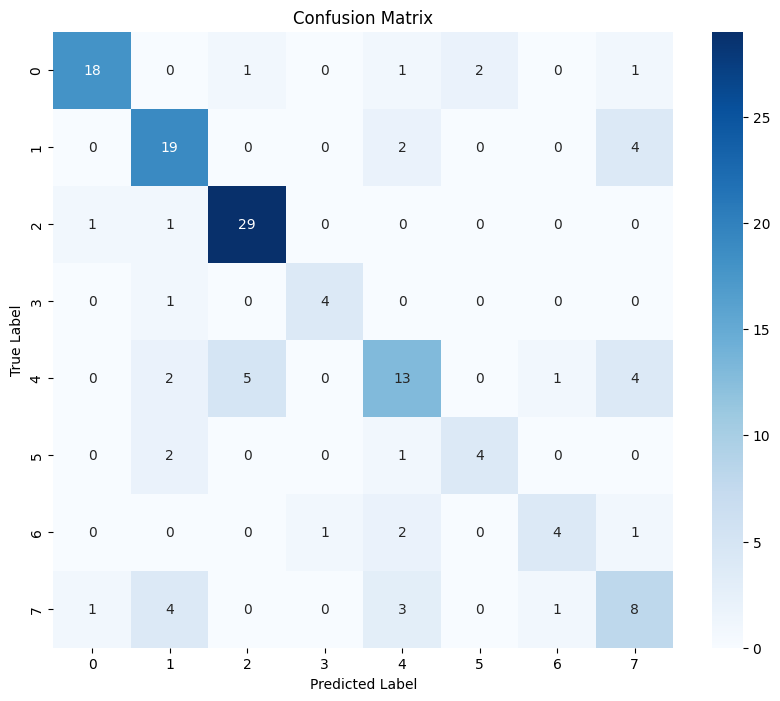

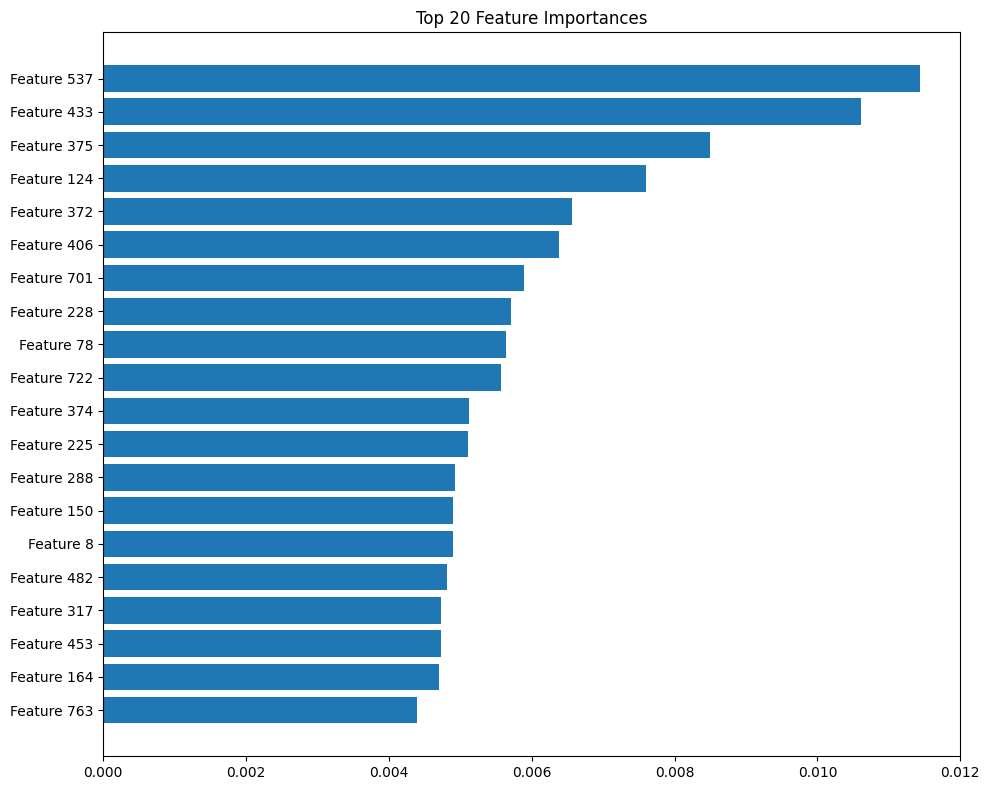

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
import torch
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('processed_dataset_7.csv', encoding='ISO-8859-1')
df["Category"] = df["Category"].str.strip().str.lower()
df = df[df["Category"] != "703"].reset_index(drop=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def enhanced_preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens
                     if token not in stop_words and len(token) > 2]
    return ' '.join(cleaned_tokens)
df['processed_description'] = df['Grievance Description'].apply(enhanced_preprocess_text)
df['word_count'] = df['processed_description'].apply(lambda x: len(x.split()))
df['char_count'] = df['processed_description'].apply(len)
if 'Complaint Keywords' in df.columns and not df['Complaint Keywords'].isna().all():
    df['processed_keywords'] = df['Complaint Keywords'].apply(enhanced_preprocess_text)
    df['combined_text'] = df['processed_description'] + ' ' + df['processed_keywords']
    df['keyword_count'] = df['processed_keywords'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
else:
    df['combined_text'] = df['processed_description']
    df['keyword_count'] = 0
from nltk.util import ngrams
def extract_ngrams(text, n=2):
    tokens = text.split()
    n_grams = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in n_grams]
df['bigrams'] = df['combined_text'].apply(lambda x: extract_ngrams(x, 2))
df['trigrams'] = df['combined_text'].apply(lambda x: extract_ngrams(x, 3))
labeled_df = df.dropna(subset=['Category']).reset_index(drop=True)
label_encoder = LabelEncoder()
labeled_df['encoded_category'] = label_encoder.fit_transform(labeled_df['Category'])
category_counts = labeled_df['Category'].value_counts()
print(f"Number of categories: {len(category_counts)}")
print(f"Category distribution:\n{category_counts.head(10)}")
X_train, X_test, y_train, y_test = train_test_split(
    labeled_df[['combined_text', 'word_count', 'char_count', 'keyword_count']],
    labeled_df['encoded_category'],
    test_size=0.2,
    random_state=42,
    stratify=labeled_df['encoded_category']
)
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Increased from 5000
    ngram_range=(1, 3),  # Include trigrams
    min_df=2,
    max_df=0.9,         # Remove terms that appear in more than 90% of documents
    use_idf=True,
    sublinear_tf=True,   # Apply sublinear tf scaling (1 + log(tf))
    norm='l2'
)
embedder = SentenceTransformer("paraphrase-mpnet-base-v2")  # Upgrade from MiniLM to MPNet
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['combined_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['combined_text'])
X_train_bert = embedder.encode(X_train['combined_text'].tolist(), batch_size=8, convert_to_numpy=True)
X_test_bert = embedder.encode(X_test['combined_text'].tolist(), batch_size=8, convert_to_numpy=True)
X_train_num = X_train[['word_count', 'char_count', 'keyword_count']].values
X_test_num = X_test[['word_count', 'char_count', 'keyword_count']].values
X_train_combined = np.hstack((X_train_bert, X_train_num))
X_test_combined = np.hstack((X_test_bert, X_test_num))
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
lr_model = LogisticRegression(
    C=10,
    max_iter=1000,
    solver='saga',
    penalty='l1',
    class_weight=class_weight_dict,
    multi_class='multinomial',
    random_state=42,
    n_jobs=-1
)
svm_model = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    class_weight=class_weight_dict,
    probability=True,
    random_state=42
)
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('svm', svm_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)
print("Training ensemble model on BERT embeddings + numerical features...")
ensemble_model.fit(X_train_combined, y_train)
lr_tfidf = LogisticRegression(C=10, max_iter=1000, class_weight=class_weight_dict, random_state=42)
print("Training Logistic Regression on TF-IDF features...")
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_ensemble = ensemble_model.predict(X_test_combined)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)
print(f"Ensemble Model Accuracy (BERT + numerical): {ensemble_accuracy:.4f}")
print(f"TF-IDF Logistic Regression Accuracy: {tfidf_accuracy:.4f}")
ensemble_proba = ensemble_model.predict_proba(X_test_combined)
tfidf_proba = lr_tfidf.predict_proba(X_test_tfidf)
final_proba = 0.7 * ensemble_proba + 0.3 * tfidf_proba
final_predictions = np.argmax(final_proba, axis=1)
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Weighted Ensemble Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
target_names = [f"{i}:{cat}" for i, cat in enumerate(label_encoder.classes_)]
print(classification_report(y_test, final_predictions, target_names=target_names))
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
misclassified = y_test != final_predictions
if np.any(misclassified):
    y_test_misclassified = y_test[misclassified]
    y_pred_misclassified = final_predictions[misclassified]
    misclassification_counts = {}
    for true, pred in zip(y_test_misclassified, y_pred_misclassified):
        pair = (true, pred)
        misclassification_counts[pair] = misclassification_counts.get(pair, 0) + 1
    print("\nTop 10 most common misclassifications:")
    for (true, pred), count in sorted(misclassification_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        true_label = label_encoder.inverse_transform([true])[0]
        pred_label = label_encoder.inverse_transform([pred])[0]
        print(f"True: {true_label}, Predicted: {pred_label}, Count: {count}")
if hasattr(ensemble_model.estimators_[2], 'feature_importances_'):
    feature_importance = ensemble_model.estimators_[2].feature_importances_
    top_features_count = min(20, len(feature_importance))
    top_indices = np.argsort(feature_importance)[-top_features_count:]
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_features_count), feature_importance[top_indices])
    plt.yticks(range(top_features_count), [f"Feature {i}" for i in top_indices])
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
import pickle
artifacts = {
    'label_encoder_11': label_encoder,
    'tfidf_vectorizer_11': tfidf_vectorizer,
    'ensemble_model_11': ensemble_model,
    'lr_tfidf_11': lr_tfidf,
    'embedder_11': embedder
}
for name, artifact in artifacts.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(artifact, f)
print("\nModel artifacts saved separately as pickle files.")